# Generate Images from demo RealisticRendering

This ipython notebook can be found in `client/examples/generate-images.ipynb`. Before you start, please read the [Tutorial: Getting Started](getting_started.html) first.

In [1]:
print 'The version of this ipython notebook:'
!git rev-parse --short HEAD

The version of this ipython notebook:
311870d


First, we need to load some python libraries for this tutorial.

In [2]:
# Functions are defined in ipynb_util.py and loaded here, this makes version control easier.
from ipynb_util import Namedict 
import os, sys, time, re, json
import numpy as np
from scipy import misc # for imread
imread = misc.imread # use this instead of the imread in matplotlib

# Load unrealcv python client, assume working directory is client/examples
sys.path.append('..')
import ue4cv

# Load matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Connect to the game

In [3]:
ue4cv.client.connect()
if not ue4cv.client.isconnected():
    print 'UnrealCV server is not running. Run the game downloaded from http://unrealcv.github.io first.'

INFO:ue4cv:204:Got connection confirm: 'connected to RealisticRendering'


In [4]:
# Show help message
# ue4cv.client.request?

In [5]:
# Test connection
res = ue4cv.client.request('vget /unrealcv/status')
print res

Is Listening
Client Connected
9000



## Read a camera trajectory from a file

Define a function to read a camera trajectory from a file

In [6]:
# %load -s read_camera_info ipynb_util.py
def read_camera_info(filename):
    with open(filename) as f:
        lines = f.readlines()
    # Parse camera location and rotation from file
    camera_pos = []
    for line_id in range(len(lines)):
        line = lines[line_id].strip() # Remove \n at the end
        if line_id % 3 == 0: # filename
            pass
        elif line_id % 3 == 1: # location
            location = [float(v) for v in line.split(' ')]
        elif line_id % 3 == 2: # Rotation
            rotation = [float(v) for v in line.split(' ')]
            camera_pos.append((location, rotation))
    return camera_pos


We will read a camera trajectory from `realistic_rendering_camera_info.txt`. This file contains a camera trajectory with 10 frames. The camera trajectory is recorded with another python script.

In [7]:
camera_pos = read_camera_info('./realistic_rendering_camera_info.txt')
print camera_pos[0] # camera location and rotation

([0.0, 0.0, 136.335], [341.382, 297.717, 0.0])


## Render images using the camera trajectory

Define a function to render an image and its annotation

In [8]:
# %load -s render_frame ipynb_util.py
def render_frame(client, cam_pose=None):
    ''' If you want to render a frame using current camera position, leave the pos argument to None '''
    if pos is not None:
        # Set camera position
        loc = cam_pose[0] # location
        rot = cam_pose[1] # rotation
        cmd = 'vset /camera/0/location %.3f %.3f %.3f' % (loc[0], loc[1], loc[2])
        response = client.request(cmd)
        assert response == 'ok'
        cmd = 'vset /camera/0/rotation %.3f %.3f %.3f' % (rot[0], rot[1], rot[2])
        response = client.request(cmd)
        assert response == 'ok'

    f = Namedict(
        lit = client.request('vget /camera/0/lit'),
        depth = client.request('vget /camera/0/depth'),
        object_mask = client.request('vget /camera/0/object_mask'),
        normal = client.request('vget /camera/0/normal'),
    )
    return f


Define a utility function for plotting images

In [9]:
# %load -s subplot_image ipynb_util.py
def subplot_image(sub_index, image):
    if isinstance(image, str):
        image = imread(image)
    plt.subplot(sub_index)
    plt.imshow(image)
    plt.axis('off')


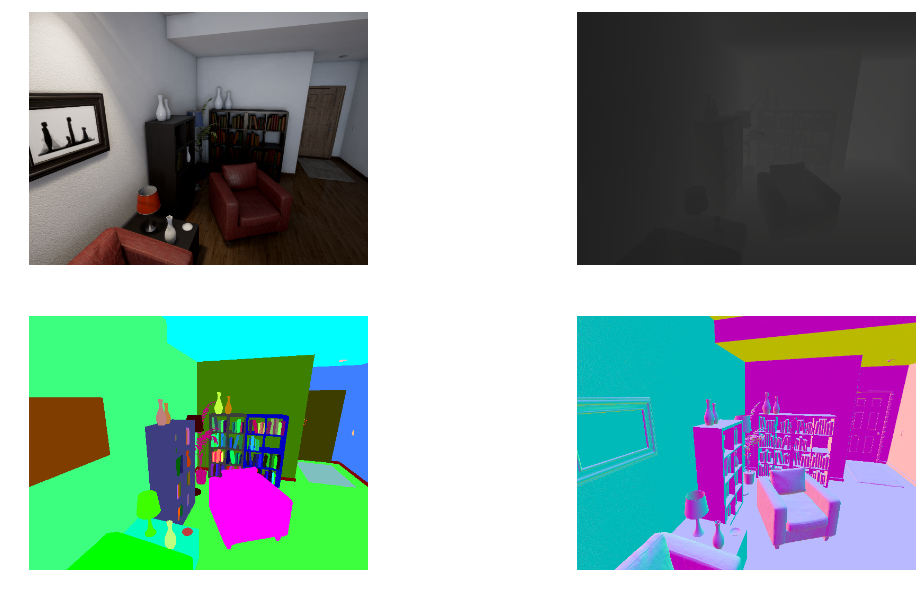

In [10]:
pos = camera_pos[1]
frame = render_frame(ue4cv.client, pos)

plt.rcParams['figure.figsize'] = (18.0, 10.0) # (w, h)
subplot_image(221, frame.lit)
subplot_image(222, frame.depth)
subplot_image(223, frame.object_mask)
subplot_image(224, frame.normal)

# for demostration purpose, here we just render one frame. If you want to generate all frames of the trajectory
# simpley do
# frames = [render_frame(ue4cv.client, pos) for pos in camera_pos]

## Parse the object instance mask

Here we have the a color map of object instance, then we need to know the color for each object


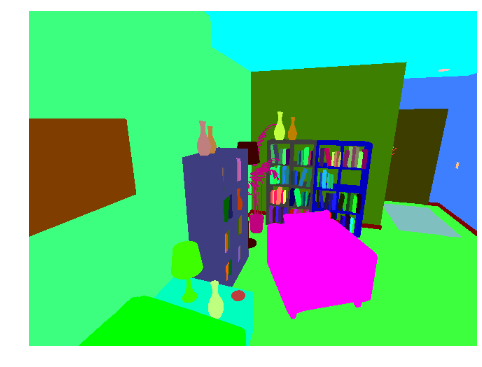

In [11]:
plt.rcParams['figure.figsize'] = (8, 6) # (w, h)
subplot_image(111, frame.object_mask)

print '''Here we have the a color map of object instance, then we need to know the color for each object''' 

In [12]:
# Get a list of all objects in the scene
scene_objects = ue4cv.client.request('vget /objects').split(' ')
print 'There are %d objects in this scene' % len(scene_objects)

There are 295 objects in this scene


In [13]:
# %load -s Color,subplot_color ipynb_util.py
class Color(object):
    regexp = re.compile('\(R=(.*),G=(.*),B=(.*),A=(.*)\)')
    def __init__(self, color_str):
        self.color_str = color_str
        match = self.regexp.match(color_str)
        (self.R, self.G, self.B, self.A) = [int(match.group(i)) for i in range(1,5)]

    def __repr__(self):
        return self.color_str

def subplot_color(index, color, title):
    plt.subplot(index)
    im = np.zeros((100, 100, 4))
    # red = np.array([1.0, 0, 0, 1.0])
    color_array = np.array([color.R, color.G, color.B, color.A]) / 255.0 # repmat
    im = im + color_array
    print title, color
    plt.imshow(im)
    plt.axis('off')
    plt.title(title)


If we want to know the color of a specific object, we can use command `vget /object/[str]/color`. `[str]` is the object name. We first iterate all objects of the scene and get their color.

In [14]:
# %load -s get_color_mapping ipynb_util.py
def get_color_mapping(client, object_list):
    ''' Get the color mapping for specified objects '''
    color_mapping = {}
    for objname in object_list:
        color_mapping[objname] = Color(client.request('vget /object/%s/color' % objname))
    return color_mapping


WallPiece1_22 (R=63,G=255,B=127,A=255)
SM_Shelving_6 (R=63,G=63,B=127,A=255)
SM_Couch_1seat_5 (R=255,G=0,B=255,A=255)
SM_Frame_39 (R=127,G=63,B=0,A=255)


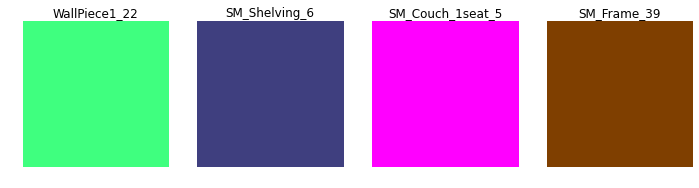

In [15]:
color_mapping = get_color_mapping(ue4cv.client, scene_objects)
selected_objects = ['WallPiece1_22', 'SM_Shelving_6', 'SM_Couch_1seat_5', 'SM_Frame_39']
plt.rcParams['figure.figsize'] = (12.0, 6.0) # (w, h)

baseindex = 100 + 10 * len(selected_objects) + 1
for i in range(len(selected_objects)):
    object_name = selected_objects[i]
    color = color_mapping[object_name]
    subplot_color(baseindex+i, color, object_name)

Given we know the labeling color for each object, we can compute the object instance mask for each object.

In [16]:
# %load -s match_color,compute_instance_mask ipynb_util.py
def match_color(color_image, target_color, tolerance=3): # Tolerance is used to solve numerical issue
    match_region = np.ones(color_image.shape[0:2], dtype=bool)
    for c in range(3): # Iterate over three channels
        min_val = target_color[c]-tolerance; max_val = target_color[c]+tolerance
        channel_region = (color_image[:,:,c] >= min_val) & (color_image[:,:,c] <= max_val)
        # channel_region = color_image[:,:,c] == target_color[c]
        match_region &= channel_region
    return match_region

def compute_instance_mask(object_mask, color_mapping, objects):
    if isinstance(object_mask, str):
        object_mask = misc.imread(object_mask)

    dic_instance_mask = {}
    for object_name in objects:
        color = color_mapping[object_name]
        region = match_color(object_mask, [color.R, color.G, color.B], tolerance=3)
        if region.sum() != 0: # Present in the image
            dic_instance_mask[object_name] = region
    return dic_instance_mask


In [17]:
# Compute the binary mask for each object instance
dic_instance_mask = compute_instance_mask(frame.object_mask, color_mapping, scene_objects)
# dic_instance_mask[object_name] can return the binary mask of the object

In [18]:
# Do some correctness test
import ipynb_util
reload(ipynb_util)
from ipynb_util import check_coverage
covered = check_coverage(dic_instance_mask)
# plt.imshow(covered)

Coverage 1.00


In [19]:
# %load -s plot_image_with_mask ipynb_util.py
def plot_image_with_mask(image, mask):
    '''
    Mask is a binary matrix, only mask==1 will be plotted
    '''
    if isinstance(image, str):
        image = imread(image)
    subplot_image(121, image)
    masked_image = image.copy()
    masked_image[~mask] = 0
    subplot_image(122, masked_image)


In [20]:
# Load object category for each object
with open('object_category.json') as f:
    dic_objects_category = json.load(f)
categories = set(dic_objects_category.values())

In [21]:
print 'Num of objects in the scene:', len(scene_objects)
image_objects = dic_instance_mask.keys()
print 'Num of objects in this image:', len(image_objects)
print 'All objects in this image'
print '%20s : %s' % ('Category Name', 'Object Name')
for obj_type in categories:
    objects = [v for v in image_objects if dic_objects_category[v] == obj_type]
    if len(objects) > 6: # Trim the list if too long
        objects[6:] = []
        objects.append('...')
    if len(objects) != 0:
        print '%20s : %s' % (obj_type, objects)

Num of objects in the scene: 295
Num of objects in this image: 131
All objects in this image
       Category Name : Object Name
            Shelving : ['SM_Shelving_7', 'SM_Shelving_6', 'SM_Shelving_9', 'SM_Shelving_8']
                Bowl : ['SM_Bowl_29']
               Couch : ['SM_Couch_1seat_5', 'Couch_13']
                Book : ['BookLP_139', 'BookLP_153', 'BookLP_134', 'BookLP_135', 'BookLP_136', 'BookLP_137', '...']
            DeskLamp : ['SM_DeskLamp_5']
     CoatHookBacking : ['CoatHookBacking_7']
               Plant : ['SM_Plant_8']
                Door : ['SM_Door_39']
          Trim_Floor : ['S_Trim_Floor_10']
                Vase : ['SM_Vase_22', 'SM_Vase_21', 'SM_Vase_20', 'SM_Vase_18', 'SM_Vase_16', 'SM_Vase_17']
              Carpet : ['Carpet_7']
                Room : ['SM_Room_7']
           FloorLamp : ['SM_FloorLamp_7']
              Switch : ['Switch_7']
               Frame : ['SM_Frame_39']
           WallPiece : ['WallPiece6_32', 'WallPiece2_24', 'WallPiece

If we want to plot the region of an object instance

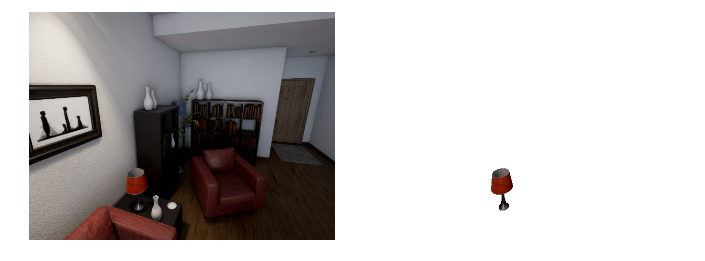

In [22]:
plot_image_with_mask(frame.lit, dic_instance_mask['SM_DeskLamp_5'])

If we want to plot the region of an object category

In [23]:
# %load -s get_category_mask ipynb_util.py
def get_category_mask(category):
    mask = None
    for obj in image_objects:
        if dic_objects_category[obj] == category:
            if mask is None:
                mask = dic_instance_mask[obj]
            else:
                mask += dic_instance_mask[obj]
    if mask is None:
        print 'Error: the mask is empty'
    return mask


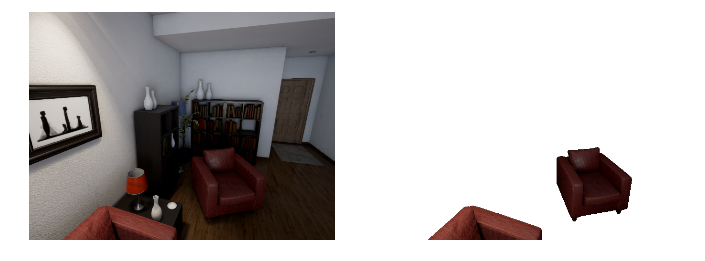

In [24]:
mask = get_category_mask('Couch')
plot_image_with_mask(frame.lit, mask)